# Haystack + Burr integration

Haystack is a Python library to build AI pipelines. It assembles `Component` objects into a `Pipeline`, which is a graph of operations. One benefit of Haystack is that it provides many pre-built components to manage documents and interact with LLMs.

This notebook shows how to convert a Haystack `Component` into a Burr `Action` and a `Pipeline` into a `Graph`. This allows you to integrate Haystack with Burr and leverage other Burr and Burr UI features!

## Native Haystack
The next cells show how to build a simple RAG pipeline using Haystack. You create the components and add them to the pipeline using `.add_component()`. Then, you need to specify connections between components using `.connect()`.

In [2]:
# Use your OpenAI API key to execute the pipeline in later cells.
import os
os.environ["OPENAI_API_KEY"] = "sk-..."

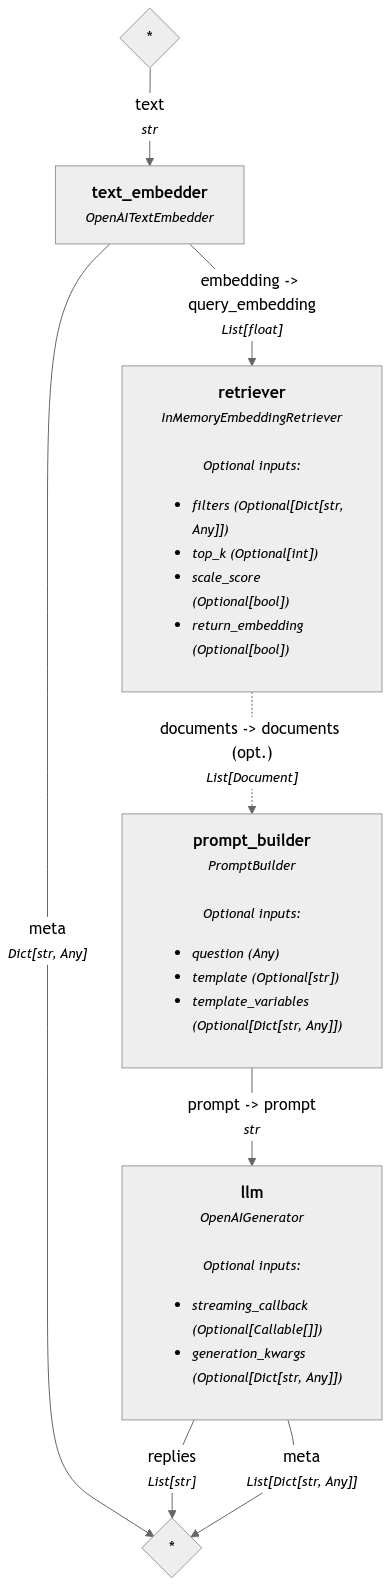

In [4]:
from haystack.components.embedders import OpenAITextEmbedder
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack import Pipeline


# 1. create components
document_store = InMemoryDocumentStore()
text_embedder = OpenAITextEmbedder(model="text-embedding-3-small")
prompt_builder = PromptBuilder(template="Document: {{documents}} Question: {{question}}")
retriever = InMemoryEmbeddingRetriever(document_store)
generator = OpenAIGenerator(model="gpt-4o-mini")

# 2. create pipeline
basic_rag_pipeline = Pipeline()

# 3. add components to the pipeline
basic_rag_pipeline.add_component("text_embedder", text_embedder)
basic_rag_pipeline.add_component("retriever", retriever)
basic_rag_pipeline.add_component("prompt_builder", prompt_builder)
basic_rag_pipeline.add_component("llm", generator)

# 4. connect components
basic_rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
basic_rag_pipeline.connect("retriever", "prompt_builder.documents")
basic_rag_pipeline.connect("prompt_builder", "llm")

basic_rag_pipeline.show()

Without using any integration, you could use Haystack within Burr's `actions`. The next is illustrative of how it can work.

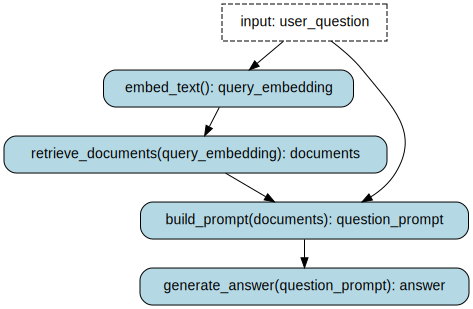

In [5]:
from burr.core import action, State, ApplicationBuilder


@action(reads=[], writes=["query_embedding"])
def embed_text(state: State, user_question: str) -> State:
    text_embedder = OpenAITextEmbedder(model="text-embedding-3-small")

    results = text_embedder.run(text=user_question)
    return state.update(query_embedding=results["embedding"])


@action(reads=["query_embedding"], writes=["documents"])
def retrieve_documents(state: State) -> State:
    query_embedding = state["query_embedding"]

    document_store = InMemoryDocumentStore()
    retriever = InMemoryEmbeddingRetriever(document_store)

    results = retriever.run(query_embedding=query_embedding)
    return state.update(documents=results["documents"])


@action(reads=["documents"], writes=["question_prompt"])
def build_prompt(state: State, user_question: str) -> State:
    documents = state["documents"]

    prompt_builder = PromptBuilder(template="Document: {{documents}} Question: {{question}}")

    results = prompt_builder.run(documents=documents, question=user_question)   
    return state.update(question_prompt=results["prompt"])


@action(reads=["question_prompt"], writes=["answer"])
def generate_answer(state: State) -> State:
    question_prompt = state["question_prompt"]

    generator = OpenAIGenerator(model="gpt-4o-mini")

    results = generator.run(prompt=question_prompt)
    return state.update(answer=results["text"])


app = (
    ApplicationBuilder()
    .with_actions(
        embed_text,
        retrieve_documents,
        build_prompt,
        generate_answer
    )
    .with_transitions(
        ("embed_text", "retrieve_documents"),
        ("retrieve_documents", "build_prompt"),
        ("build_prompt", "generate_answer"))
    .with_entrypoint("embed_text")
    .build()
)
app.visualize(include_state=True)

Notes:
- Instead of using `Component` objects, we wrap them into `@action` decorated functions.
- While Haystack pipelines allow components to communicate via sockets, Burr relies on a centralized state.
- Burr requires building the `Graph` "all at once" via the `ApplicationBuilder` or `GraphBuilder` while Haystack allows to incrementally add `.add_component()` and `.connect()` statements to the pipeline.
- Haystack allows the parameters of `Component.run()` to be provided by other components via sockets or from the user inputs. Burr separates the two via the `State` object or the function arguments given through `.run(inputs=...)`.
- Haystack `Component` are objects, meaning they need to be instantiated and are stateful. Burr `Action` are stateless, which allows to resume runs from any `State` and enable "time-travel debugging".
- Haystack uses a `Router` component to [expression conditional edges](https://docs.haystack.deepset.ai/reference/routers-api#conditionalrouter). Burr allows to add condition directly via the `.with_transitions()` method by specifying in the tuple `(from_action, to_action, condition)`.

## Burr's `HaystackAction`

To avoid having to wrap each component into an `@action` function, the `HaystackAction` was added to Burr. It takes an instantiated `Component`, a `name`, and the `reads/writes` of the action.

The next cell shows two identical actions, one without the integration (taken from the previous section) and one using `HaystackAction`.


In [6]:
from burr.integrations.haystack import HaystackAction

@action(reads=["query_embedding"], writes=["documents"])
def retrieve_documents(state: State) -> State:
    query_embedding = state["query_embedding"]

    document_store = InMemoryDocumentStore()
    retriever = InMemoryEmbeddingRetriever(document_store)
    
    results = retriever.run(query_embedding=query_embedding)
    return state.update(documents=results["documents"])


haystack_retrieve_documents = HaystackAction(
    component=InMemoryEmbeddingRetriever(InMemoryDocumentStore()),
    name="retrieve_documents",
    reads=["query_embedding"],
    writes=["documents"],
)

The next cell shows the entire application using the `HaystackAction` integration. The action `display_answer` defined using `@action` was added to show you can can combine both approaches.

Note that some for some `HaystackAction`, `reads` and `writes` are dictionaries instead of the usual lists. This helps map the values from the Burr `State` to the Haystack `Component.run()` parameters and outputs. 

For example, in `generate_answer`:
 - `reads={"prompt": "question_prompt"}` takes the value `State["question_prompt"]` and assigns it to `Component.run(prompt=...)`
 - `writes={"answer": "replies"}` takes the value `Component.run(...)["replies"]` and assigns it to `state.update(answer=...)`

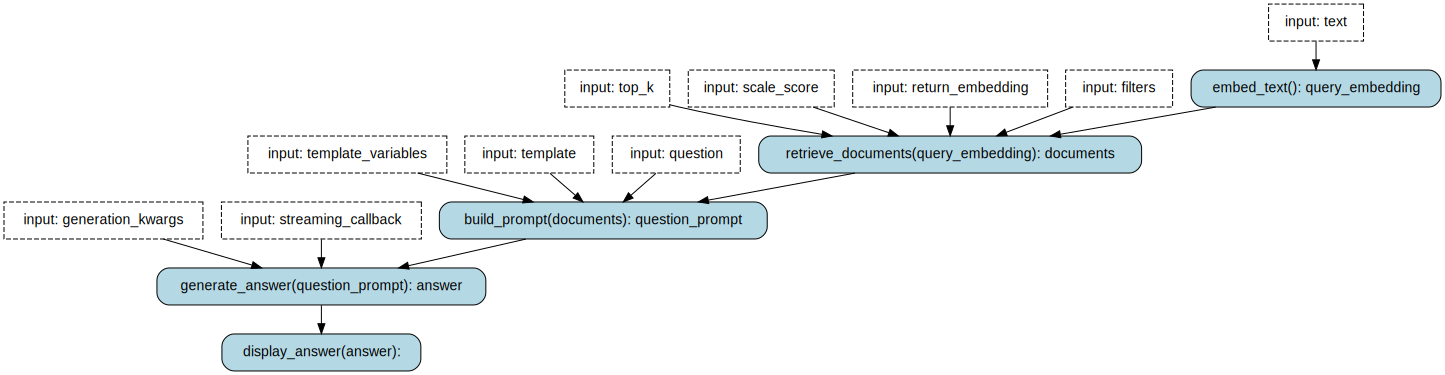

In [7]:
from burr.core import action, State, ApplicationBuilder

embed_text = HaystackAction(
    component=OpenAITextEmbedder(model="text-embedding-3-small"),
    name="embed_text",
    reads=[],
    writes={"query_embedding": "embedding"},
)

retrieve_documents = HaystackAction(
    component=InMemoryEmbeddingRetriever(InMemoryDocumentStore()),
    name="retrieve_documents",
    reads=["query_embedding"],
    writes=["documents"],
)

build_prompt = HaystackAction(
    component=PromptBuilder(template="Document: {{documents}} Question: {{question}}"),
    name="build_prompt",
    reads=["documents"],
    writes={"question_prompt": "prompt"},
)

generate_answer = HaystackAction(
    component=OpenAIGenerator(model="gpt-4o-mini"),
    name="generate_answer",
    reads={"prompt": "question_prompt"},
    writes={"answer": "replies"}
)

@action(reads=["answer"], writes=[])
def display_answer(state: State) -> State:
    print(state["answer"])
    return state


app = (
    ApplicationBuilder()
    .with_actions(
        embed_text,
        retrieve_documents,
        build_prompt,
        generate_answer,
        display_answer,
    )
    .with_transitions(
        ("embed_text", "retrieve_documents"),
        ("retrieve_documents", "build_prompt"),
        ("build_prompt", "generate_answer"),
        ("generate_answer", "display_answer"),
    )
    .with_entrypoint("embed_text")
    .build()
)
app.visualize(include_state=True)

### Running the application
To run the application, we specify when to halt execution and pass the question to two input fields: `text` and `question` (this matches the native Haystack API ([see **Asking a Question**](https://haystack.deepset.ai/tutorials/27_first_rag_pipeline))).

You'll see a note that no documents were embedded or retrieved, but you should see the answer generated by the LLM nonetheless!

In [8]:
_, results, state = app.run(
    halt_after=["display_answer"],
    inputs={
        "text": "What is the capital of France?",
        "question": "What is the capital of France?",
    }
)

No Documents found with embeddings. Returning empty list. To generate embeddings, use a DocumentEmbedder.


['The capital of France is Paris.']


In [21]:
print(results)

{'replies': ['The capital of France is Paris.'], 'meta': [{'model': 'gpt-4o-mini-2024-07-18', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 7, 'prompt_tokens': 19, 'total_tokens': 26, 'completion_tokens_details': CompletionTokensDetails(audio_tokens=None, reasoning_tokens=0), 'prompt_tokens_details': PromptTokensDetails(audio_tokens=None, cached_tokens=0)}}]}


## Converting a Haystack `Pipeline`

If you have an existing Haystack `Pipeline`, you can convert it into a Burr `Graph` using in a single line of code using `haystack_pipeline_to_burr_graph()`.

Next, we convert the `basic_rag_pipeline` defined at the beginning of the notebook. The resulting `Graph` can be passed to the `ApplicationBuilder.with_graph()` clause.

The visualization should match the previous ones, but with different names (e.g., `generate_answer` is `llm`)

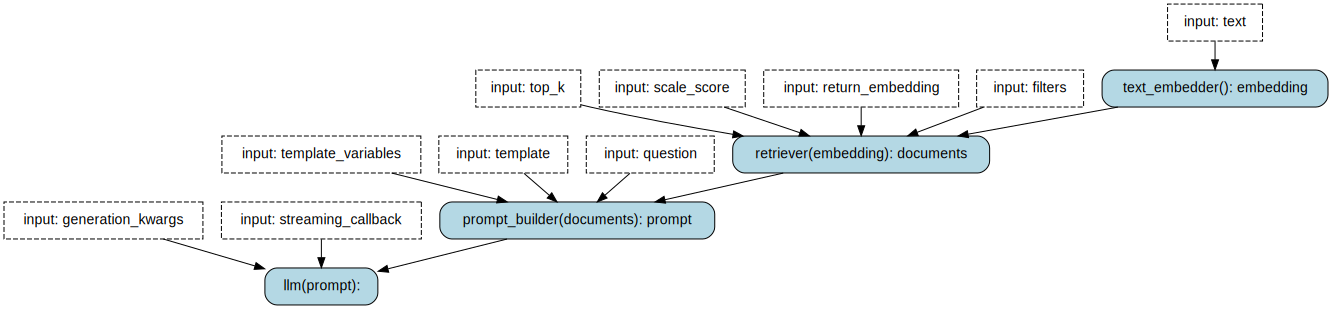

In [17]:
from burr.integrations.haystack import haystack_pipeline_to_burr_graph


haystack_graph = haystack_pipeline_to_burr_graph(basic_rag_pipeline)
app = (
    ApplicationBuilder()
    .with_graph(haystack_graph)
    .with_entrypoint("text_embedder")
    .build()
)
app.visualize(include_state=True)

When we run the converted Haystack `Pipeline`, we obtain outputs similar to the previous section.

In [18]:
_, results, state = app.run(
    halt_after=["llm"],
    inputs={
        "text": "What is the capital of France?",
        "question": "What is the capital of France?",
    }
)

No Documents found with embeddings. Returning empty list. To generate embeddings, use a DocumentEmbedder.


In [20]:
print(results)

{'replies': ['The capital of France is Paris.'], 'meta': [{'model': 'gpt-4o-mini-2024-07-18', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 7, 'prompt_tokens': 19, 'total_tokens': 26, 'completion_tokens_details': CompletionTokensDetails(audio_tokens=None, reasoning_tokens=0), 'prompt_tokens_details': PromptTokensDetails(audio_tokens=None, cached_tokens=0)}}]}
